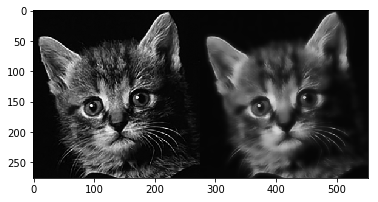

[DONE]


In [15]:
# %load guided_filter.py
#!/usr/bin/env python

from scipy.misc import imread
import numpy             as np
import scipy.misc        as sci
import matplotlib.pyplot as plot


class GuidedFilter( object ):
    @classmethod
    def _filter( cls, input: np.ndarray, r: int ) -> np.ndarray:
        limit, _    = input.shape
        result      = np.zeros_like( input )
        cumulative  = np.cumsum(input, 0)

        result[0:r+1, :]         = cumulative[r:2*r+1, :]
        result[r+1:limit-r, :]   = cumulative[2*r+1:limit, :] - cumulative[0:limit-2*r-1, :]
        result[limit-r:limit, :] = np.tile( cumulative[limit-1, :], [r, 1] ) - cumulative[limit-2*r-1:limit-r-1, :]

        return result


    @classmethod
    def box_filter( cls, image: np.ndarray, radius: int ) -> np.ndarray:
        output = cls._filter( image, radius )
        output = cls._filter( output.transpose(), radius )
        return output.transpose()


    @classmethod
    def apply(cls, guide: np.ndarray, image: np.ndarray, radius: int, epsilon: float) -> np.ndarray:

        N = cls.box_filter( np.ones_like( image ), radius )

        mean_guide             = cls.box_filter( guide, radius ) / N
        mean_image             = cls.box_filter( image, radius ) / N
        mean_guide_image       = cls.box_filter( guide * image, radius ) / N
        covariance_guide_image = mean_guide_image - mean_guide * mean_image

        mean_squared_guide = cls.box_filter( guide * guide, radius ) / N
        variance_guide     = mean_squared_guide - mean_guide * mean_guide

        a = covariance_guide_image / (variance_guide + epsilon)
        b = mean_image - a * mean_guide

        mean_a = cls.box_filter( a, radius ) / N
        mean_b = cls.box_filter( b, radius ) / N

        return mean_a * guide + mean_b



def main():
    image   = imread( 'cat.bmp' ).astype( np.float32 ) / 255.0
    radius  = 3
    epsilon = 0.05
    result  = GuidedFilter.apply(image, image, radius, epsilon)
    
    plot.imshow( np.concatenate( (image, result ), axis = 1 ), cmap = 'gray' )
    plot.show()

    print('[DONE]')
    return

if __name__ == '__main__':
    main()


`mean_guide = cls.box_filter( guide, r ) / N`
$$ \frac{1}{|\omega|} \sum_{i \in \omega_k}{\mu_k} $$

`mean_image = cls.box_filter( image, r ) / N`
$$ \frac{1}{|\omega|} \sum_{i \in \omega_k}{\bar{p_k}} $$

`mean_guide_image = cls.box_filter( guide * image, r ) / N`
$$ \frac{1}{|\omega|} \sum_{i \in \omega_k}{ I_i p_i} $$

`covariance_guide_image = mean_guide_image - mean_guide * mean_image`
$$  \frac{1}{|\omega|}\sum_{i \in \omega_k }{I_i p_i - \mu_k \bar{p_k}} $$

`a = covariance_guide_image / (variance_guide + eps)`
$$ a_k = \frac{ \frac{1}{|\omega|}\sum_{i \in \omega_k }{I_i p_i - \mu_k \bar{p_k}} }{ \sigma^{2}_{k} + \epsilon }  $$

`b = mean_image - a * mean_guide`
$$ b_k = \bar{p_k} - a_k \mu_k   $$

`return mean_a * guide + mean_b`
$$ q_i = \frac{1}{|\omega|}\sum_{k: i \in \omega_k}{(a_k I_k + b_k)} $$